<a href="https://colab.research.google.com/github/tshreegupta/ECE595DL/blob/main/Project4/gupta_tanushree_aml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Student Name: Tanushree Gupta
### ECE 595 Machine Learning II
### Project 4: Adversarial Machine Learning - Student Code

In [3]:
%tensorflow_version 1.x
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0
#!pip install tensorflow==2.7.0

TensorFlow 1.x selected.
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 154 kB 46.6 MB/s 
     |████████████████████████████████| 42 kB 966 kB/s 


In [4]:

#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
# import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2
from progressbar import progressbar

Using TensorFlow backend.


### Part 1: Training a target classifier

In [5]:
# Load data MNIST data and normalize to [0, 1]
#FILL THIS IN
(data_train,label_train),(data_test,label_test) = mnist.load_data()
data_train = data_train/255.0
data_test = data_test/255.0

#Reshape training and testing data into 784-dimensional vectors 
#FILL THIS IN
data_train_reshape = data_train.reshape(-1,784)
data_test_reshape = data_test.reshape(-1,784)

#Convert integer labels for training and testing data into one-hot vectors 
#FILL THIS IN
label_train =  keras.utils.np_utils.to_categorical(label_train,num_classes=10)
label_test =  keras.utils.np_utils.to_categorical(label_test,num_classes=10)


11493376/11490434 [==============================] - 0s 0us/step


In [6]:
#Create classifier architecture, compile it, and train it
#FILL THIS IN
def target():
    model = Sequential()
    
    #First layer
    model.add(Dense(100,activation = 'relu', input_dim=784, kernel_initializer='normal'))
    
    #Second Layer
    model.add(BatchNormalization())

    #Third Layer
    model.add(Dense(100, activation= 'relu', kernel_initializer='normal'))
    
    #Fourth Layer
    model.add(BatchNormalization())
    
    #Output Layer
    model.add(Dense(10,activation = 'softmax', kernel_initializer='normal'))
    
    return model

In [9]:
#Compile the target
attacker = target()

# Array to save training history
attacker.compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

attacker_meta_data= attacker.fit(data_train_reshape,label_train,
                                  batch_size = 256,
                                  epochs = 50,
                                  shuffle = True,
                                  validation_data = (data_test_reshape,label_test))
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.3477 - accuracy: 0.9061 - val_loss: 0.2539 - val_accuracy: 0.9539
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1107 - accuracy: 0.9670 - val_loss: 0.1018 - val_accuracy: 0.9681
Epoch 3/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0721 - accuracy: 0.9785 - val_loss: 0.0809 - val_accuracy: 0.9748
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.0823 - val_accuracy: 0.9739
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0393 - accuracy: 0.9884 - val_loss: 0.0775 - val_accuracy: 0.9774
Epoch 6/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0296 - accuracy: 0.9913 - val_loss: 0.0788 - val_acc

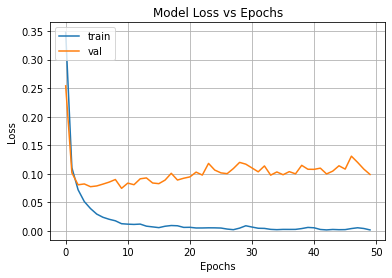

In [10]:
#Plot loss vs epoch
#FILL THIS IN
plt.plot(attacker_meta_data.history['loss'])
plt.plot(attacker_meta_data.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss vs Epochs")
plt.grid(True)
plt.legend(['train','val'],loc='upper left')
plt.show()

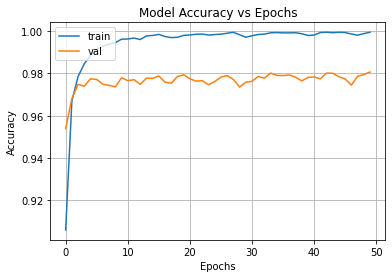

In [11]:
#Plot accuracy vs epoch
#FILL THIS IN
plt.plot(attacker_meta_data.history['accuracy'])
plt.plot(attacker_meta_data.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs Epochs")
plt.grid(True)
plt.legend(['train','val'],loc='upper left')
plt.show()

In [12]:
#Print accuracy of classifier on MNIST testing data
#FILL THIS IN
acc = attacker.evaluate(data_test_reshape,label_test)
print("Accuracy of the classifier = %.2f%%" %(acc[1]*100))

10000/10000 [==============================] - 0s 30us/step
Accuracy of the classifier = 98.06%


In [13]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block

#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(attacker)

### Part 2: The Fast Gradient Method (FGM)

In [44]:
# import tensorflow.compat.v1 as tf

#Implementing the FGSM attack
# backend.set_learning_phase(0)
#FGM Instance on trained classifier from Part 1
#FILL THIS IN
fgm = FastGradientMethod(wrap,sess=sess)

#Attack parameters
#FILL THIS IN
fgm_param = {'eps': 0.25,'clip_min' : 0.0, 'clip_max' : 1.0}

#Generate adversarial data
#FILL THIS IN
adversial_test_data = fgm.generate_np(data_test_reshape, **fgm_param)
#Evaluate accuracy on target classifier 
#FILL THIS IN
acc = attacker.evaluate(adversial_test_data,label_test)
print("Accuracy of the classifier with FGM= %.2f%%" %(acc[1]*100))

10000/10000 [==============================] - 0s 33us/step
Accuracy of the classifier with FGM= 6.62%


(-0.5, 27.5, 279.5, -0.5)

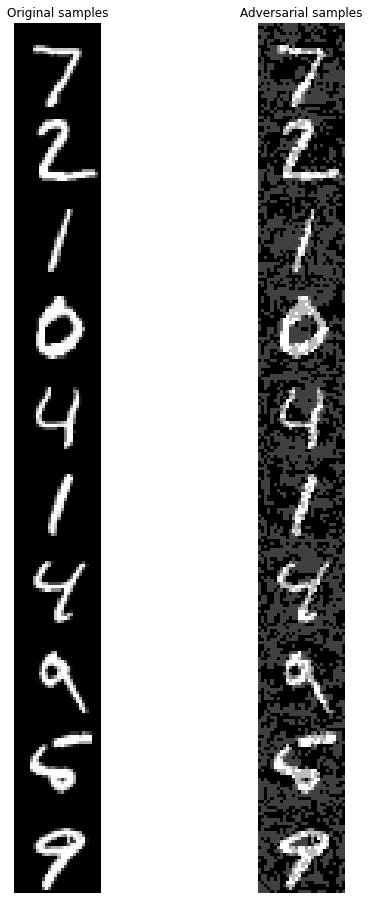

In [46]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN
r = 10
c = 2
fig = plt.figure(figsize = (8,16))
plt.gray()
ax = fig.add_subplot(1,2,1)
ax.imshow(data_test_reshape[0:10].reshape(-1,28))
ax.set_title('Original samples')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(adversial_test_data[0:10].reshape(-1,28))
ax.set_title('Adversarial samples')
ax.axis('off')

In [47]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
#FILL THIS IN
encoder = autoencoder()

encoder.compile(loss=['mean_squared_error'],
                      optimizer='adam',
                      metrics=['accuracy'])

encoder.fit(data_train_reshape, data_train_reshape,
            batch_size = 256,
            epochs = 50,
            shuffle= True,
            validation_data=(data_test_reshape,data_test_reshape))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 159us/step - loss: 0.0370 - accuracy: 0.0107 - val_loss: 0.0146 - val_accuracy: 0.0097
Epoch 2/50
60000/60000 [==============================] - 9s 146us/step - loss: 0.0117 - accuracy: 0.0120 - val_loss: 0.0090 - val_accuracy: 0.0124
Epoch 3/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.0082 - accuracy: 0.0130 - val_loss: 0.0069 - val_accuracy: 0.0137
Epoch 4/50
60000/60000 [==============================] - 9s 144us/step - loss: 0.0066 - accuracy: 0.0127 - val_loss: 0.0057 - val_accuracy: 0.0112
Epoch 5/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.0056 - accuracy: 0.0121 - val_loss: 0.0051 - val_accuracy: 0.0129
Epoch 6/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.0050 - accuracy: 0.0128 - val_loss: 0.0045 - val_accuracy: 0.0132
Epoch 7/50
60000/60000 [==============================] - 9s 

In [57]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
#FILL THIS IN
adversial_train_data = fgm.generate_np(data_train_reshape, **fgm_param)

# Obtain reconstruction errors on training set and determine a threshold 
#FILL THIS IN
fgm_reconstruct = encoder.predict(adversial_train_data)
error = keras.losses.mean_squared_error(fgm_reconstruct,data_train_reshape)

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)
 # Determine threshold (based on min in this case) and print it 
#FILL THIS IN
threshold = np.min(error)
print("Threshold = %2f"%(threshold))

# Calculate error of adversarial testing set
#FILL THIS IN
fgm_reconstruct = encoder.predict(adversial_test_data)
error= keras.losses.mean_squared_error(fgm_reconstruct, adversial_test_data)
error = error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
#FILL THIS IN
positive_count = np.size(np.where(error>threshold))

# Print number of true positive samples
#FILL THIS IN  
print("Number of true positive samples = %d"%(positive_count))

# Determine false positives on benign testing set
#FILL THIS IN 
fgm_reconstruct = encoder.predict(data_test_reshape)
error = keras.losses.mean_squared_error(fgm_reconstruct,data_test_reshape)
error = error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
#FILL THIS IN 
positive_count = np.size(np.where(error>threshold))

# Print number of false positive samples
#FILL THIS IN 
print("Number of false positive samples = %d"%(positive_count))

Threshold = 0.005494
Number of true positive samples = 10000
Number of false positive samples = 132


#Part 3: Projected Gradient Descent

In [14]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
#FILL THIS IN
pgd_param = {'eps': 0.25, 'eps_iter':0.01, 'nb_iter':20, 'clip_min':0.0,'clip_max':1.0}

#Generate adversarial data
#FILL THIS IN
pgd_data = pgd.generate_np(data_test_reshape,**pgd_param)

#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN
acc = attacker.evaluate(pgd_data, label_test)
print("Accuracy with Projected Gradient Descent =  %2f%%"%(acc[1]*100))



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

10000/10000 [==============================] - 0s 28us/step
Accuracy with Projected Gradient Descent =  1.090000%


(-0.5, 27.5, 279.5, -0.5)

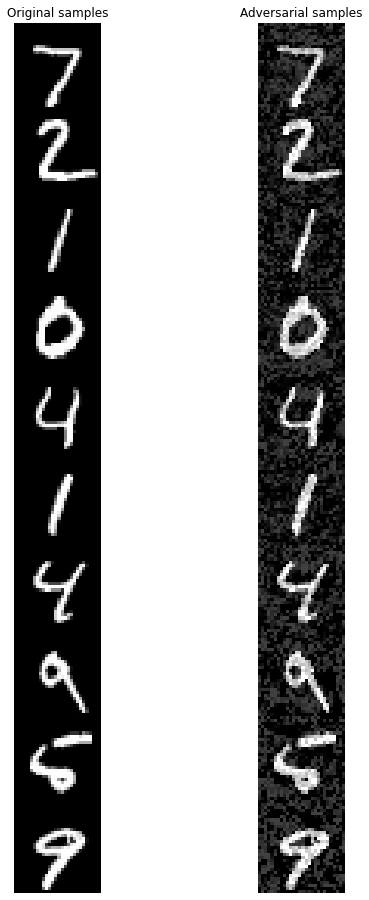

In [15]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN 
r = 10
c = 2
fig = plt.figure(figsize = (8,16))
plt.gray()
ax = fig.add_subplot(1,2,1)
ax.imshow(data_test_reshape[0:10].reshape(-1,28))
ax.set_title('Original samples')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(pgd_data[0:10].reshape(-1,28))
ax.set_title('Adversarial samples')
ax.axis('off')

In [16]:
#Implementing the adversarial training defense
#FILL THIS IN
pgd_train_data = pgd.generate_np(data_train_reshape,**pgd_param)


adv_trained_clf  = target()

# Array to save training history
adv_trained_clf.compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

adv_trained_clf_meta_data= adv_trained_clf.fit(np.concatenate([data_train_reshape,pgd_train_data]),np.concatenate([label_train,label_train]),
                                  batch_size = 256,
                                  epochs = 50,
                                  shuffle = True,
                                  validation_data = (pgd_data,label_test))

Train on 120000 samples, validate on 10000 samples
Epoch 1/50
120000/120000 [==============================] - 4s 36us/step - loss: 0.2104 - accuracy: 0.9438 - val_loss: 0.1172 - val_accuracy: 0.9773
Epoch 2/50
120000/120000 [==============================] - 4s 32us/step - loss: 0.0602 - accuracy: 0.9820 - val_loss: 0.1225 - val_accuracy: 0.9778
Epoch 3/50
120000/120000 [==============================] - 4s 31us/step - loss: 0.0409 - accuracy: 0.9874 - val_loss: 0.1233 - val_accuracy: 0.9794
Epoch 4/50
120000/120000 [==============================] - 4s 31us/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.1368 - val_accuracy: 0.9789
Epoch 5/50
120000/120000 [==============================] - 4s 31us/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.1400 - val_accuracy: 0.9777
Epoch 6/50
120000/120000 [==============================] - 4s 32us/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.1393 - val_accuracy: 0.9786
Epoch 7/50
120000/120000 [=============================

In [19]:
#Using the defense to evaluate the accuracy of the perturbed data
#FILL THIS IN 
acc = adv_trained_clf.evaluate(pgd_data,label_test)
print("Accuracy of the classifier with Advanced Defense= %.2f%%" %(acc[1]*100))

10000/10000 [==============================] - 0s 29us/step
Accuracy of the classifier with Advanced Defense= 98.01%


#Part 4: Carlini and Wagner Attack

In [20]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
#FILL THIS IN
cw = CarliniWagnerL2(wrap, sess=sess)

#Attack parameters
#FILL THIS IN
cw_params = {'binary_search_steps': 1, 'y': None, 'learning_rate': 1.25, 'batch_size': 16, 
             'initial_const': 10, 'clip_min': 0.0, 'clip_max': 1.0}

#Generate adversarial data
#FILL THIS IN
cw_test_data = cw.generate_np(data_test_reshape,**cw_params)

#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN
acc = attacker.evaluate(cw_test_data,label_test)
print("Accuracy of the classifier with CW= %.2f%%" %(acc[1]*100))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
10000/10000 [==============================] - 0s 28us/step
Accuracy of the classifier with CW= 1.36%


(-0.5, 27.5, 279.5, -0.5)

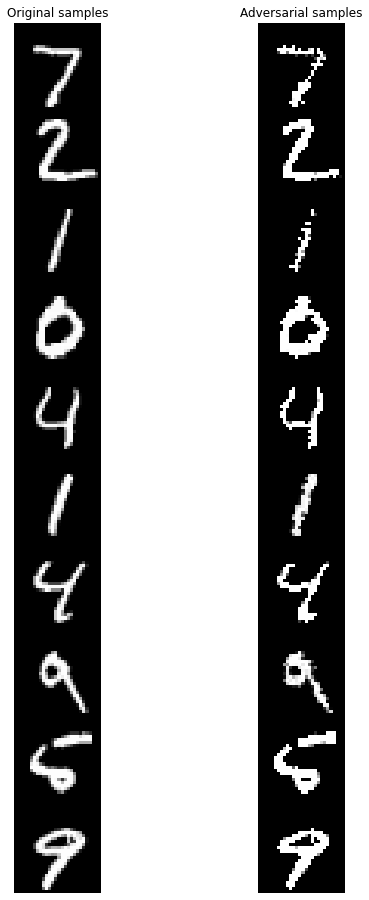

In [21]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN 
r = 10
c = 2
fig = plt.figure(figsize = (8,16))
plt.gray()
ax = fig.add_subplot(1,2,1)
ax.imshow(data_test_reshape[0:10].reshape(-1,28))
ax.set_title('Original samples')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(cw_test_data[0:10].reshape(-1,28))
ax.set_title('Adversarial samples')
ax.axis('off')

In [28]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train_reshape)
pca_train = pca.transform(data_train_reshape)
pca_test = pca.transform(data_test_reshape)

#Transform perturbed CW data using the subspace from the original training data
#FILL THIS IN 
pca_cw_test = pca.transform(cw_test_data)

In [23]:
# create model for PCA
def pca_model():
    model = Sequential()
    
    #FILL THIS IN
    model.add(Dense(units = 100, activation='relu',input_dim=100))
    model.add(BatchNormalization())
    model.add(Dense(units = 100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units = 10, activation='softmax'))

    return model

#Create model graph, compile it, and train it using pca_train lables_train 
#FILL THIS IN 
#Compile the target
pca_defence = pca_model()

# Array to save training history
pca_defence.compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

pca_defence_meta_data= pca_defence.fit(pca_train,label_train,
                                  batch_size = 256,
                                  epochs = 50,
                                  shuffle = True,
                                  validation_data = (pca_test,label_test))
    


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.5001 - accuracy: 0.8510 - val_loss: 0.2218 - val_accuracy: 0.9440
Epoch 2/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1575 - accuracy: 0.9550 - val_loss: 0.1293 - val_accuracy: 0.9621
Epoch 3/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1053 - accuracy: 0.9693 - val_loss: 0.1028 - val_accuracy: 0.9702
Epoch 4/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0774 - accuracy: 0.9778 - val_loss: 0.0908 - val_accuracy: 0.9734
Epoch 5/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0599 - accuracy: 0.9827 - val_loss: 0.0833 - val_accuracy: 0.9755
Epoch 6/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0481 - accuracy: 0.9862 - val_loss: 0.0775 - val_accuracy: 0.9772
Epoch 7/50
60000/60000 [==============================] - 1s 17us/s

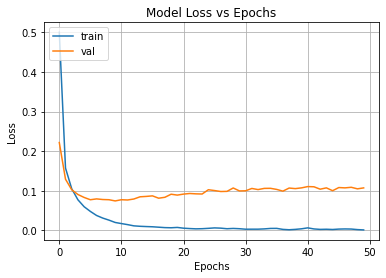

In [24]:
#Plot loss vs epoch
#FILL THIS IN
plt.plot(pca_defence_meta_data.history['loss'])
plt.plot(pca_defence_meta_data.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss vs Epochs")
plt.grid(True)
plt.legend(['train','val'],loc='upper left')
plt.show()

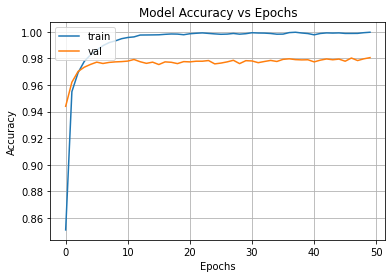

In [25]:
#Plot accuracy vs epoch
#FILL THIS IN
plt.plot(pca_defence_meta_data.history['accuracy'])
plt.plot(pca_defence_meta_data.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs Epochs")
plt.grid(True)
plt.legend(['train','val'],loc='upper left')
plt.show()

In [29]:
#Using the defense (and comparing to baseline accuracy)
#FILL THIS IN 
acc = pca_defence.evaluate(pca_cw_test,label_test)
print("Accuracy of the classifier with FGM= %.2f%%" %(acc[1]*100))

10000/10000 [==============================] - 0s 26us/step
Accuracy of the classifier with FGM= 85.92%


#Part 5: DeepFool 

In [30]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
#FILL THIS IN
df = DeepFool(wrap, sess=sess)

#Attack parameters
#FILL THIS IN
df_params = {'nb_candidate': 10, 'max_iter': 50, 'clip_min': 0.0, 'clip_max': 1.0}

#Generate adversarial data
#FILL THIS IN
df_test_data = df.generate_np(data_test_reshape,**df_params)

#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN
acc = attacker.evaluate(df_test_data,label_test)
print("Accuracy of the classifier with DeepFool= %.2f%%" %(acc[1]*100))

10000/10000 [==============================] - 0s 29us/step
Accuracy of the classifier with DeepFool= 1.34%


(-0.5, 27.5, 279.5, -0.5)

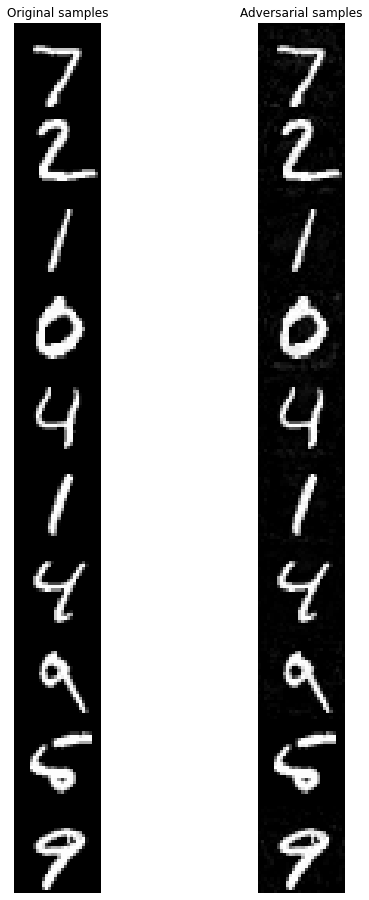

In [31]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN
r = 10
c = 2
fig = plt.figure(figsize = (8,16))
plt.gray()
ax = fig.add_subplot(1,2,1)
ax.imshow(data_test_reshape[0:10].reshape(-1,28))
ax.set_title('Original samples')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(df_test_data[0:10].reshape(-1,28))
ax.set_title('Adversarial samples')
ax.axis('off')

In [35]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = df.generate_np(data_train_reshape, **df_params)
data_total_train = np.concatenate([df_attack_data_train, data_train_reshape])

#Create and train DAE graph
#FILL THIS IN
df_defence = autoencoder()
df_defence.compile(loss=['categorical_crossentropy'],
                      optimizer='adam',
                      metrics=['accuracy'])

df_defence.fit(data_total_train, data_total_train,
            batch_size = 256,
            epochs = 50,
            shuffle= True)

Epoch 1/50
120000/120000 [==============================] - 18s 150us/step - loss: 575.5076 - accuracy: 0.0079
Epoch 2/50
120000/120000 [==============================] - 17s 146us/step - loss: 554.7646 - accuracy: 0.0124
Epoch 3/50
120000/120000 [==============================] - 17s 145us/step - loss: 552.0827 - accuracy: 0.0139
Epoch 4/50
120000/120000 [==============================] - 18s 146us/step - loss: 550.9040 - accuracy: 0.0139
Epoch 5/50
120000/120000 [==============================] - 17s 146us/step - loss: 550.1815 - accuracy: 0.0146
Epoch 6/50
120000/120000 [==============================] - 18s 147us/step - loss: 549.7205 - accuracy: 0.0153
Epoch 7/50
120000/120000 [==============================] - 18s 148us/step - loss: 549.3462 - accuracy: 0.0160
Epoch 8/50
120000/120000 [==============================] - 18s 148us/step - loss: 549.0706 - accuracy: 0.0165
Epoch 9/50
120000/120000 [==============================] - 18s 148us/step - loss: 548.8741 - accuracy: 0.0171
E

In [42]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
#FILL THIS IN
df_free_data = df_defence.predict(df_test_data)

#Evaluate accuracy of FGM samples after denoising 
#FILL THIS IN
acc = attacker.evaluate(fgm_test_data,label_test)
print("Accuracy of the classifier with DAE = %.2f%%" %(acc[1]*100))

10000/10000 [==============================] - 0s 33us/step
Accuracy of the classifier with DAE = 79.57%


(-0.5, 27.5, 279.5, -0.5)

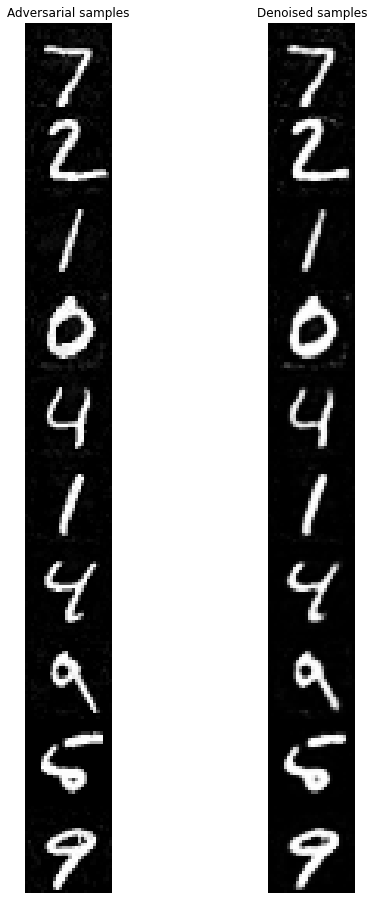

In [39]:
#Show ten samples of adversarial samples after denoising
#FILL THIS IN
r = 10
c = 2
fig = plt.figure(figsize = (8,16))
plt.gray()
ax = fig.add_subplot(1,2,1)
ax.imshow(df_test_data[0:10].reshape(-1,28))
ax.set_title('Adversarial samples')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(df_free_data[0:10].reshape(-1,28))
ax.set_title('Denoised samples')
ax.axis('off')